In [3]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import warnings
warnings.filterwarnings('ignore')

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [15]:
df = pd.read_csv('이상치제거.csv', encoding= 'cp949')
# 한국 일일확진자 변수 제거
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df

,시점,시군산지,일자,품종,도매가격.원.kg.,거래량.톤.,거래금액.백만원.,마늘.면적..ha.,X10a당.생산량..kg.,생산량..톤.,X10a당.생산량.톤,평균,평균기온..C.,일강수량.mm.,평균.풍속.m.s.,합계.일조시간.hr.,평균.지면온도..C.,평균.5cm.지중온도..C.
0,2015,철원,2015-07-11,기타,5833,0.020,0.11,307,777,2385,0.777,0.020000,19.655000,6.984375,1.670718,6.382320,21.770166,22.154190
1,2015,철원,2015-07-10,기타,6875,0.020,0.11,307,777,2385,0.777,0.020000,19.635556,6.984375,1.661326,6.392265,21.734254,22.115642
2,2015,평창,2015-08-06,햇마늘 한지,10000,0.010,0.10,307,777,2385,0.777,0.010000,19.214917,7.308475,1.570166,6.323204,21.660773,22.070950
3,2015,홍천,2015-09-21,저장형 한지,3125,0.040,0.13,307,777,2385,0.777,0.040000,15.548066,7.444286,1.483425,4.768508,17.203867,17.888268
4,2016,강릉,2016-07-02,햇마늘 한지,2500,0.040,0.10,180,807,1452,0.807,0.040000,20.027072,11.755263,1.431492,6.052486,23.000552,22.607735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1347,2020,횡성,2020-09-03,깐마늘,5500,0.006,0.03,236,1049,2476,1.049,0.074962,17.055801,12.382278,1.549171,4.667403,20.296133,19.737017
1348,2020,횡성,2020-07-31,깐마늘,5300,0.010,0.07,236,1049,2476,1.049,0.074962,19.151381,11.896591,1.540331,4.939227,22.667403,21.890608
1349,2020,횡성,2020-08-07,깐마늘,4900,0.010,0.07,236,1049,2476,1.049,0.074962,18.760221,12.016092,1.549171,4.937017,22.270718,21.537017
1350,2020,횡성,2020-06-01,마늘쫑,5245,0.030,0.17,236,1049,2476,1.049,0.074962,16.776796,10.508046,1.856906,5.798343,19.967403,19.060221


In [18]:
df.Date = pd.to_datetime(df.일자)
#df['dayofweek'] = df['Date'].dt.dayofweek
df.set_index('일자', inplace=True)

In [21]:
lag_col= list(df.columns)


In [24]:
lag_amount = 3

for col in lag_col:
    for i in range(lag_amount):
        df['{0}_lag{1}'.format(col,i+1)] = df['{}'.format(col)].shift(i+1)
    
df.dropna(inplace=True)

In [27]:
df.tail()

,시점,시군산지,품종,도매가격.원.kg.,거래량.톤.,거래금액.백만원.,마늘.면적..ha.,X10a당.생산량..kg.,생산량..톤.,X10a당.생산량.톤,...,평균.풍속.m.s._lag3,합계.일조시간.hr._lag1,합계.일조시간.hr._lag2,합계.일조시간.hr._lag3,평균.지면온도..C._lag1,평균.지면온도..C._lag2,평균.지면온도..C._lag3,평균.5cm.지중온도..C._lag1,평균.5cm.지중온도..C._lag2,평균.5cm.지중온도..C._lag3
일자,,,,,,,,,,,,,,,,,,,,,
2020-09-03,2020,횡성,깐마늘,5500,0.006,0.03,236,1049,2476,1.049,...,1.545304,5.713260,5.025967,4.942541,19.027624,21.740884,22.090608,18.143646,21.005525,21.351381
2020-07-31,2020,횡성,깐마늘,5300,0.010,0.07,236,1049,2476,1.049,...,1.535912,4.667403,5.713260,5.025967,20.296133,19.027624,21.740884,19.737017,18.143646,21.005525
2020-08-07,2020,횡성,깐마늘,4900,0.010,0.07,236,1049,2476,1.049,...,1.875138,4.939227,4.667403,5.713260,22.667403,20.296133,19.027624,21.890608,19.737017,18.143646
2020-06-01,2020,횡성,마늘쫑,5245,0.030,0.17,236,1049,2476,1.049,...,1.549171,4.937017,4.939227,4.667403,22.270718,22.667403,20.296133,21.537017,21.890608,19.737017
2020-09-21,2020,횡성,깐마늘,5700,0.020,0.11,236,1049,2476,1.049,...,1.540331,5.798343,4.937017,4.939227,19.967403,22.270718,22.667403,19.060221,21.537017,21.890608


In [28]:
# 데이터 프레임 형태 확인
print("전체 데이터 shape: {}".format(df.shape))

전체 데이터 shape: (1349, 68)


In [33]:
# 데이터 프레임 형태 확인
print("전체 데이터 shape: {}".format(df.shape))
print("target feature shape: {}".format(df['도매가격.원.kg.'].shape))

전체 데이터 shape: (1349, 68)
target feature shape: (1349,)


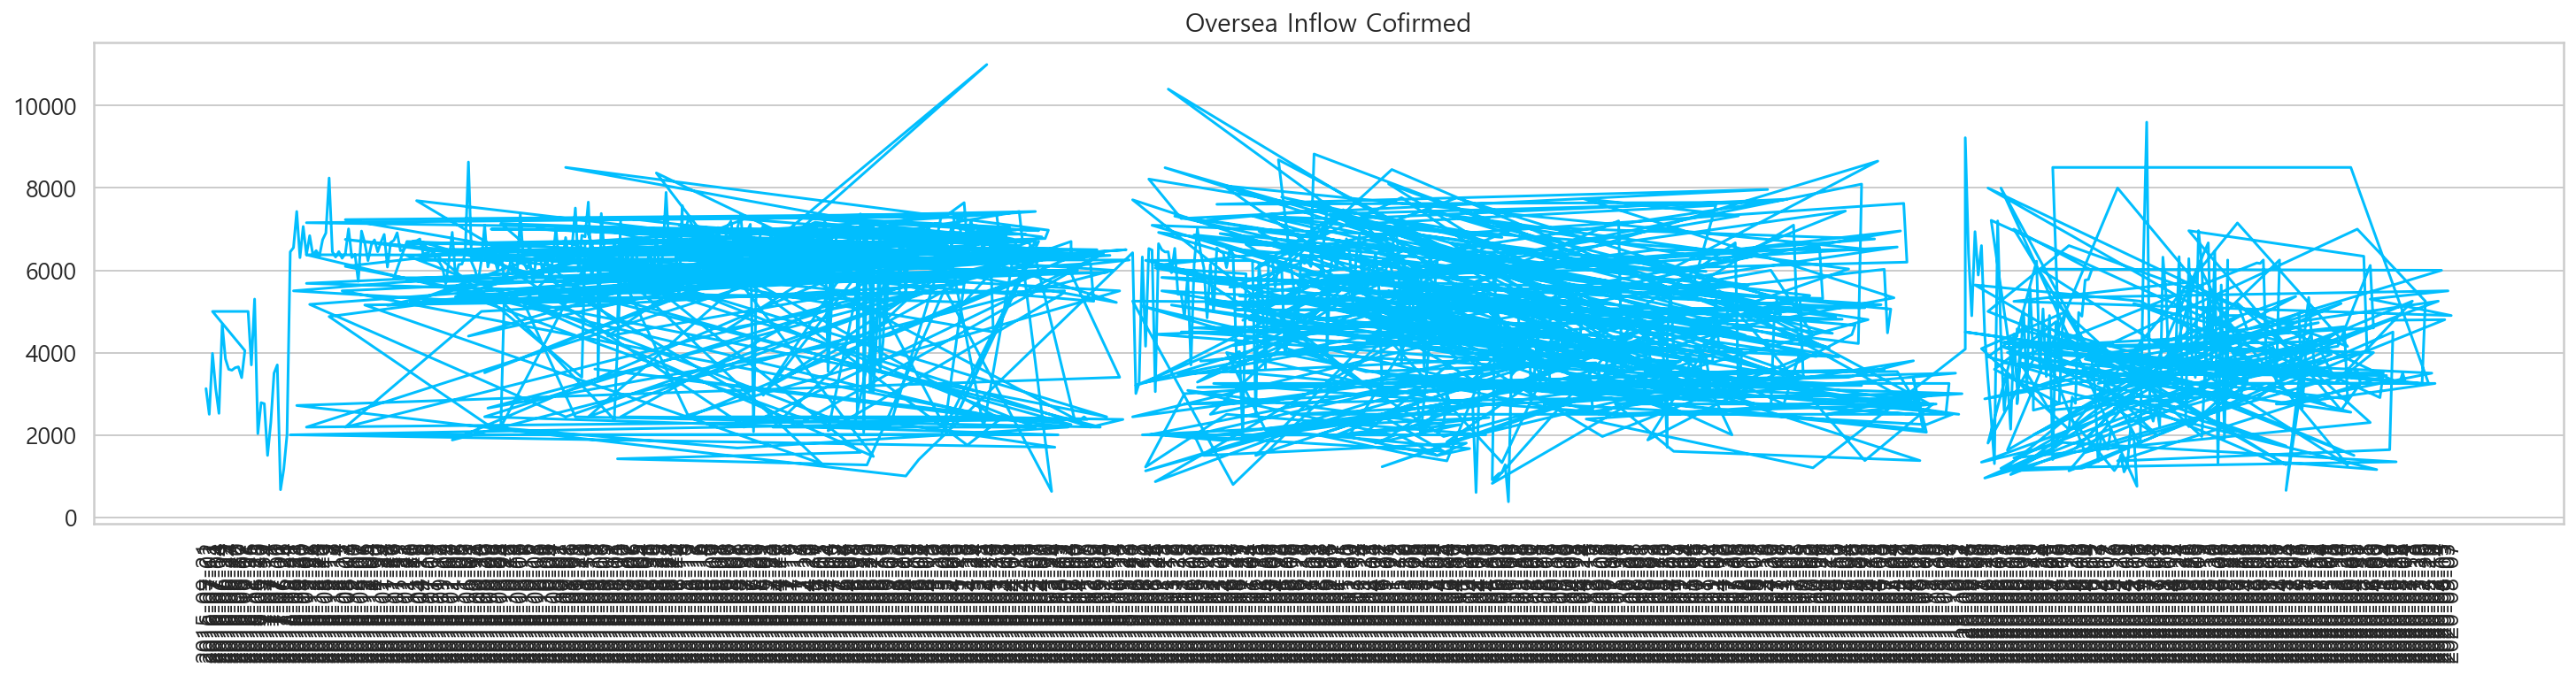

In [35]:
plt.figure(figsize=(25,5))
plt.plot(df['도매가격.원.kg.'])
plt.xticks(rotation=90)
plt.title("Oversea Inflow Cofirmed")
plt.grid(axis='x')